In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
import os
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI

In [2]:
np.random.seed(42)
# load api key from .env file
load_dotenv()
api_key = os.getenv("OPENROUTER_API_KEY")

if not api_key:
    print("ERROR: OPENROUTER_API_KEY not found in .env file")
    print("Get your API key from: https://openrouter.ai/keys")
    print("Add it to your .env file as: OPENROUTER_API_KEY=your_key_here")
    raise ValueError("Missing OPENROUTER_API_KEY")

print(f"API Key loaded: {api_key[:10]}..." if len(api_key) > 10 else "API Key too short")

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
    default_headers={
        "HTTP-Referer": "http://localhost:3000",  
        "X-Title": "Yelp Review Analysis",  
    }
)

model = "openai/gpt-4o-mini"

API Key loaded: sk-or-v1-a...


In [3]:
df = pd.read_csv("/Users/muaazshaikh/fynd/notebook/yelp.csv")

In [4]:
print(f"Total reviews: {len(df)}")

Total reviews: 10000


In [5]:
print(f"Columns: {df.columns.tolist()}")

Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']


In [6]:
df_sample = df.groupby('stars', group_keys=False).apply(lambda x: x.sample(min(len(x), 200 // 5), random_state=42)).reset_index(drop=True)

/var/folders/zj/_rj3h7ts2bs9nsq6r37cw72r0000gn/T/ipykernel_21407/392248651.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('stars', group_keys=False).apply(lambda x: x.sample(min(len(x), 200 // 5), random_state=42)).reset_index(drop=True)


In [7]:
print(f"\nSampled {len(df_sample)} reviews")
print("\nRating distribution:")
print(df_sample['stars'].value_counts().sort_index())


Sampled 200 reviews

Rating distribution:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


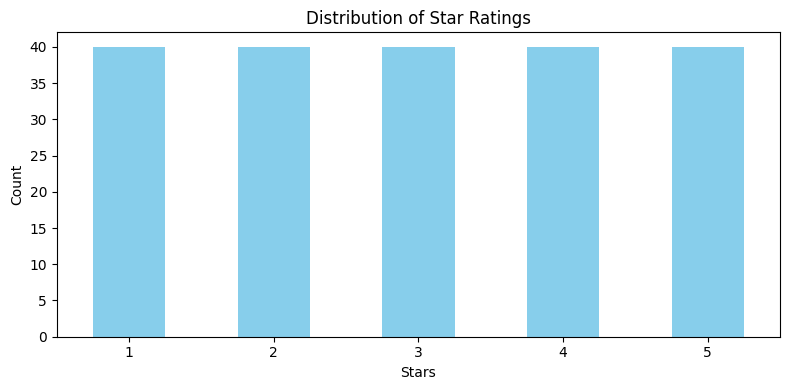

In [8]:
plt.figure(figsize=(8, 4))
df_sample['stars'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
def prompt_v1(review_text):
    return f"""Read this restaurant review and predict the star rating from 1 to 5.

    Review: {review_text}

    Think about:
    - What's the overall feeling? Happy, frustrated, mixed?
    - Would they go back?
    - Any strong words like "amazing" or "terrible"?

    Give me your answer as JSON:
    {{
    "predicted_stars": <number 1-5>,
    "explanation": "<why you chose this rating>"
    }}
"""

In [10]:
def prompt_v2(review_text):
    
    return f"""Let's figure out the star rating for this restaurant review. Think it through step by step.

    Review: {review_text}

    Walk through this:
    1. What's the overall vibe? Are they excited, disappointed, or somewhere in between?
    2. Do they mention specific good things or bad things?
    3. How strong is their language? Words like "great" and "love" mean something different than "okay" or "fine"
    4. Would they recommend this place to a friend?

    Based on your thinking, what rating makes sense?
    - 5 stars = Loved it, everything was great
    - 4 stars = Really good, would go back
    - 3 stars = It was okay, nothing special
    - 2 stars = Pretty disappointed, had problems
    - 1 star = Terrible experience, avoid this place

    Response as JSON:
    {{
    "predicted_stars": <number 1-5>,
    "explanation": "<your reasoning>"
    }}
"""

In [11]:
def prompt_v3(review_text):
    return f"""Here are some examples of how to rate restaurant reviews:

    Example 1:
    "The food was amazing! Service was perfect and the atmosphere was wonderful. Can't wait to go back!"
    5 stars (enthusiastic language, wants to return, no complaints)

    Example 2:
    "Good food and decent service. Nothing really stood out but we enjoyed ourselves. Would probably go back."
    4 stars (positive overall but not exceptional, would return)

    Example 3:
    "Food was okay. Service was slow but the server was nice. It's fine but nothing special."
    3 stars (lukewarm language like "okay" and "fine", mixed feelings)

    Example 4:
    "Disappointed with the quality. Food was cold and took forever. Probably won't return."
    2 stars (clear disappointment, won't return, specific complaints)

    Example 5:
    "Absolutely terrible. Rude staff, disgusting food, overpriced. Never going back and don't recommend it."
    1 star (strong negative words, multiple serious issues, warns others)
    
    Now rate this review using the same approach:

    Review: {review_text}

    What rating fits best? Consider:
    - The intensity of language (is it strong or mild?)
    - Whether they'd return
    - If there are specific complaints or praise
    - The overall tone

    Response as JSON:
    {{
    "predicted_stars": <number 1-5>,
    "explanation": "<your reasoning>"
    }}
"""


In [12]:
def predict_rating(review_text, prompt_function, max_retries: int = 3) :

    prompt = prompt_function(review_text)
    
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0.2,
                max_tokens=500,
            )
            response_text = response.choices[0].message.content.strip()
            
            # clean markdown code blocks if present
            if response_text.startswith('```'):
                lines = response_text.split('\n')
                response_text = '\n'.join(lines[1:-1])
                if response_text.startswith('json'):
                    response_text = response_text[4:].strip()
            
            # parse JSON
            result = json.loads(response_text)
            
            # validate required fields
            if 'predicted_stars' not in result or 'explanation' not in result:
                raise ValueError("Missing required fields in JSON")
            
            # validate rating range
            rating = int(result['predicted_stars'])
            if rating < 1 or rating > 5:
                raise ValueError(f"Rating {rating} out of valid range (1-5)")
            
            return {
                'predicted_stars': rating,
                'explanation': result['explanation'],
                'json_valid': True,
                'error': None
            }
            
        except json.JSONDecodeError as e:
            if attempt == max_retries - 1:
                print(f"JSON decode error after {max_retries} attempts: {str(e)[:50]}")
                return {
                    'predicted_stars': None,
                    'explanation': None,
                    'json_valid': False,
                    'error': f"JSON parse error: {str(e)}"
                }
            time.sleep(1)
            
        except (KeyError, ValueError) as e:
            if attempt == max_retries - 1:
                print(f"Validation error after {max_retries} attempts: {str(e)}")
                return {
                    'predicted_stars': None,
                    'explanation': None,
                    'json_valid': False,
                    'error': str(e)
                }
            time.sleep(1)
            
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Unexpected error: {str(e)[:50]}")
                return {
                    'predicted_stars': None,
                    'explanation': None,
                    'json_valid': False,
                    'error': str(e)
                }
            time.sleep(1)
    
    return {
        'predicted_stars': None,
        'explanation': None,
        'json_valid': False,
        'error': "Max retries exceeded"
    }

In [13]:
def evaluate(df: pd.DataFrame, prompt_func, approach):
    print(f"\n{'='*20}")
    print(f"Evaluating approach: {approach}")
    print(f"\n{'='*20}")

    actuals = []
    predictions = []
    valid_count = 0

    for idx, row in df.iterrows():
        print(f"Progress: {idx + 1}/{len(df)}")
        result = predict_rating(row['text'], prompt_func, max_retries=3)
        if result['json_valid']:
            valid_count += 1
            predictions.append(result['predicted_stars'])
            actuals.append(row['stars'])

        time.sleep(0.5)

    print("Done evaluating.")
    if predictions:
        accuracy = accuracy_score(actuals, predictions)
        print(f"  Accuracy: {accuracy:.2%}")
        print(f"  Valid JSON: {valid_count}/{len(df)}")
    else:
        accuracy = 0
        print("  No valid predictions!")
    
    return {
        'name': approach,
        'predictions': predictions,
        'actuals': actuals,
        'accuracy': accuracy,
        'valid_count': valid_count,
        'total': len(df)
    }


In [14]:
approaches = [
    (prompt_v1, "Approach 1: Simple Direct"),
    (prompt_v2, "Approach 2: Step-by-Step"),
    (prompt_v3, "Approach 3: With Examples")
]

# Run evaluations
results = {}
for prompt_func, name in approaches:
    results[name] = evaluate(df_sample, prompt_func, name)

print("\n" + "="*50)
print("All experiments completed!")
print("="*50)


Evaluating approach: Approach 1: Simple Direct

Progress: 1/200
Progress: 2/200
Progress: 3/200
Progress: 4/200
Progress: 5/200
Progress: 6/200
Progress: 7/200
Progress: 8/200
Progress: 9/200
Progress: 10/200
Progress: 11/200
Progress: 12/200
Progress: 13/200
Progress: 14/200
Progress: 15/200
Progress: 16/200
Progress: 17/200
Progress: 18/200
Progress: 19/200
Progress: 20/200
Progress: 21/200
Progress: 22/200
Progress: 23/200
Progress: 24/200
Progress: 25/200
Progress: 26/200
Progress: 27/200
Progress: 28/200
Progress: 29/200
Progress: 30/200
Progress: 31/200
Progress: 32/200
Progress: 33/200
Progress: 34/200
Progress: 35/200
Progress: 36/200
Progress: 37/200
Progress: 38/200
Progress: 39/200
Progress: 40/200
Progress: 41/200
Progress: 42/200
Progress: 43/200
Progress: 44/200
Progress: 45/200
Progress: 46/200
Progress: 47/200
Progress: 48/200
Progress: 49/200
Progress: 50/200
Progress: 51/200
Progress: 52/200
Progress: 53/200
Progress: 54/200
Progress: 55/200
Progress: 56/200
Progress


COMPARISON RESULTS
Approach                  Accuracy     Valid JSON  
--------------------
Approach 1: Simple Direct 69.0%        200/200     
Approach 2: Step-by-Step  69.0%        200/200     
Approach 3: With Examples 67.5%        200/200     


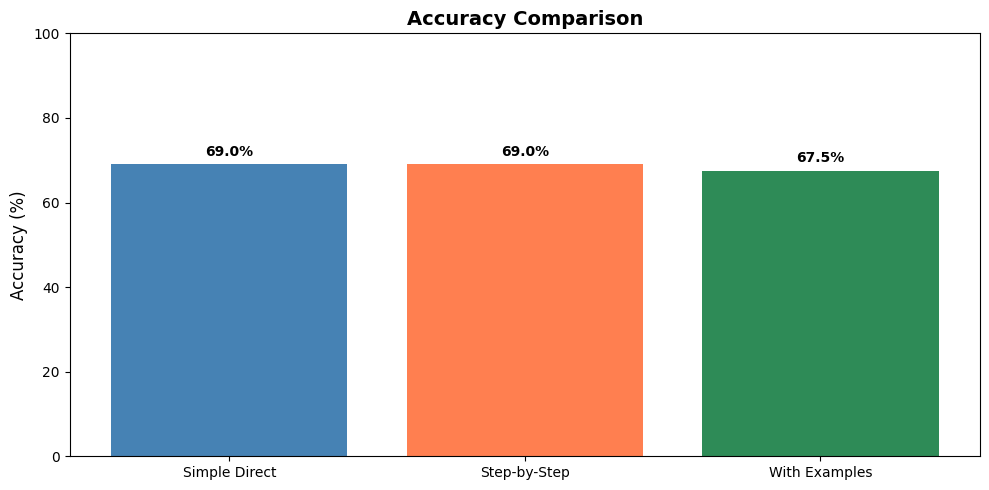


Saved comparison.png


In [15]:
# print comparison table
print("\n" + "="*20)
print("COMPARISON RESULTS")
print("="*20)
print(f"{'Approach':<25} {'Accuracy':<12} {'Valid JSON':<12}")
print("-"*20)

for name, result in results.items():
    acc = f"{result['accuracy']:.1%}"
    valid = f"{result['valid_count']}/{result['total']}"
    print(f"{name:<25} {acc:<12} {valid:<12}")

print("="*20)

# Simple bar chart
approach_names = [name.split(':')[1].strip() for name in results.keys()]
accuracies = [r['accuracy'] * 100 for r in results.values()]

plt.figure(figsize=(10, 5))
plt.bar(approach_names, accuracies, color=['steelblue', 'coral', 'seagreen'])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 100])

for i, v in enumerate(accuracies):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparison.png', dpi=150)
plt.show()

print("\nSaved comparison.png")